# Automatic Generation of Design Structure Matrices

by James Gopsill

<hr>

Design Structure Matrices (DSMs) have been extensively applied to identify and visualise product & organisational architectures across a number of engineering disciplines. They provide a crucial insight into potential interactions within engineering projects. They not only cover component dependencies but also process, system and organisational dependencieces.

Historically, the generation of a DSM typically involves surveys, structured interviews and/or
meetings with engineers involved on the project. As a consequence, there is a high cost associated
with engineers' time alongside the requirement to continually update the DSM
structure as a product develops.

Therefore, investigations have been performed into the viability of capturing and monitoring edits to project files and whether DSMs could be automatically generated from such data (Gopsill et al., 2016, ).

This python notebook takes you through the steps that these researchers have gone through in order to generate DSMs automatically from file meta-data and serves to act as an introduction for anyone who wishes to explore this field of research further.

The example uses an anonymised subset of metadata changes captured and used in the study by Gopsill et al., (2016). The data comes in the format of an SQLite database, which contains XX unique part models and xx metadata changes. The full dataset used in the studies consisted of over XX part models and XX metadata changes and was stored within a MySQL databases.

In [119]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import sqlite3
import pprint
from datetime import datetime, timedelta
import community
import operator

## Loading the SQL Data

In [120]:
conn = sqlite3.connect('example.db')
cur = conn.cursor()

pp = pprint.PrettyPrinter(indent=2)

# Present an example output from the database
cur.execute(" SELECT file_name, date_modified FROM metadata LIMIT 5")
results = cur.fetchall()
pp.pprint(results)


[ ('Complete - Assembly - 1', '2009-11-09 21:36:50'),
  ('Complete - Assembly - 1', '2010-11-03 22:06:00'),
  ('Complete - Assembly - 1', '2010-11-03 22:45:48'),
  ('Complete - Assembly - 1', '2010-11-04 18:53:27'),
  ('Complete - Assembly - 1', '2010-11-04 22:11:46')]


## Creating the list of parts and nodes for network

In [121]:
cur.execute(" SELECT file_name, COUNT(*) as count FROM metadata GROUP BY file_name")
results = cur.fetchall()

file_names = []
g = nx.Graph()
for i, result in enumerate(results):
    file_names.append(result[0])
    g.add_node(i,
              file_name=result[0],
              freq=result[1]
              )

pp.pprint(file_names[0:10])
print('Number of Nodes:', g.number_of_nodes())


[ 'Brake - Assembly - 2',
  'Brake - Assembly - 3',
  'Brake - Assembly - 4',
  'Brake - Assembly - 5',
  'Brake - Assembly - 6',
  'Brake - Assembly - 7',
  'Brake - Component - 10',
  'Brake - Component - 4',
  'Brake - Component - 5',
  'Brake - Component - 6']
Number of Nodes: 541


## Adding the Edges

In [122]:
time_delta = timedelta(hours=3)

for i, file_name in enumerate(file_names):
    cur.execute("SELECT date_modified FROM metadata WHERE file_name = ? ORDER BY date_modified ASC", (file_name,))
    results = cur.fetchall()
    dates_modified = []
    for result in results:
        dates_modified.append(datetime.strptime( result[0], '%Y-%m-%d %H:%M:%S' ))
        
    number_of_rows = len(dates_modified)
    # for each modified date
    for n in range(0, number_of_rows-1):
        # Setting the time window
        start_date = dates_modified[n]
        end_date = start_date + time_delta
        if n == number_of_rows-1:
            if end_date > dates_modified[n+1]:
                end_date = dates_modified[n+1]

        # get the parts that have been modified in that time span
        cur.execute("SELECT file_name FROM metadata WHERE date_modified > ? and date_modified < ? GROUP BY file_name", (start_date, end_date))
        results = cur.fetchall()

        for result in results:
            file_idx = file_names.index(result[0])
            if g.has_edge(i, file_idx):
                g[i][file_idx]['weight'] = g[i][file_idx]['weight'] + 1
            else:
                g.add_edge(i, file_idx, weight=1)

conn.close()
                
print('Number of Nodes:', g.number_of_nodes())
print('Number of Edges:', g.number_of_edges())


Number of Nodes: 541
Number of Edges: 62091


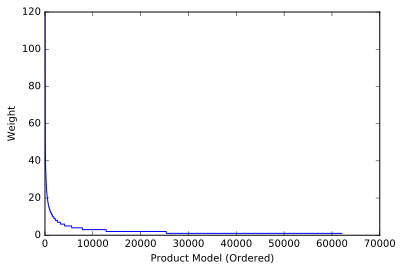

In [123]:
edge_weights = []
for u, v, d in g.edges(data=True):
    edge_weights.append(d['weight'])

edge_weights.sort(reverse=True)

plt.plot(edge_weights)
plt.ylim(0, edge_weights[0])
plt.xlabel('Product Model (Ordered)')
plt.ylabel('Weight')
plt.show()

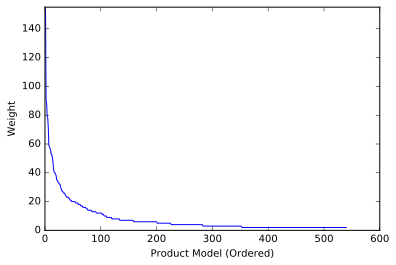

In [124]:
node_freqs = []
for u, d in g.nodes(data=True):
    node_freqs.append(d['freq'])

node_freqs.sort(reverse=True)

plt.plot(node_freqs)
plt.ylim(0, node_freqs[0])
plt.xlabel('Product Model (Ordered)')
plt.ylabel('Weight')
plt.show()

## Matrix Normalisation

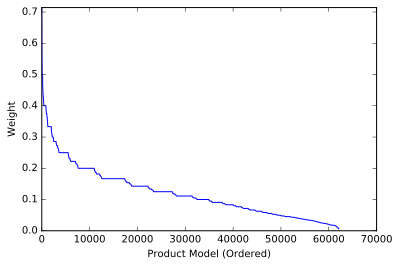

In [125]:
new_edge_weights = []
for u, v, d in g.edges_iter(data=True):
    g[u][v]['weight'] = float( g[u][v]['weight'] ) / ( float(g.node[u]['freq']) + float(g.node[v]['freq']) )
    new_edge_weights.append(g[u][v]['weight'])

new_edge_weights.sort(reverse=True)

plt.plot(new_edge_weights)
plt.ylim(0, new_edge_weights[0])
plt.xlabel('Product Model (Ordered)')
plt.ylabel('Weight')
plt.show()

## Prune Matrix


In [126]:
# remove low weighted edges
for u, v, d in g.edges(data=True):
  if d['weight'] < 0.25:
    g.remove_edge(u, v)

print('- Pruned Edges -')
print('Number of Nodes:', g.number_of_nodes())
print('Number of Edges:', g.number_of_edges())

for u, d in g.nodes(data=True):
  if d['freq'] < 3:
    g.remove_node(u)
    
print('- Pruned Node -')
print('Number of Nodes:', g.number_of_nodes())
print('Number of Edges:', g.number_of_edges())
    
# check for any leftover nodes with no 
n = 0
flag = True
while flag:
    n = n + 1
    print('Iteration:', n)
    flag = False
    for u in g.nodes():
        if g.degree(u) < 2:
            g.remove_node(u)
            flag = True
            
print('- Pruned Low Degree -')
print('Number of Nodes:', g.number_of_nodes())
print('Number of Edges:', g.number_of_edges())

- Pruned Edges -
Number of Nodes: 541
Number of Edges: 5522
- Pruned Node -
Number of Nodes: 353
Number of Edges: 3167
Iteration: 1
Iteration: 2
- Pruned Low Degree -
Number of Nodes: 348
Number of Edges: 3164


## Visualising the matrix

[[ 0.25        0.42857143  0.42857143 ...,  0.25        0.25        0.28571429]
 [ 0.42857143  0.          0.33333333 ...,  0.          0.          0.        ]
 [ 0.42857143  0.33333333  0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.25        0.          0.         ...,  0.          0.5         0.42857143]
 [ 0.25        0.          0.         ...,  0.5         0.          0.42857143]
 [ 0.28571429  0.          0.         ...,  0.42857143  0.42857143  0.        ]]


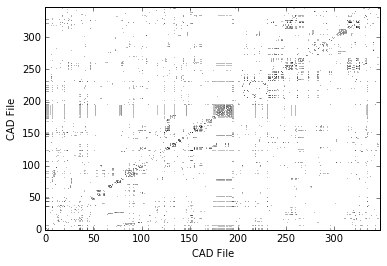

In [127]:
m = nx.to_numpy_matrix(g)
m = np.asarray(m)
print(m)

# Return to png for plotting results as these are large arrays and large svgs will crash the page
set_matplotlib_formats('png')

plt.pcolor(m, cmap='Greys', vmin=0, vmax=np.max(m))
plt.xlim(0, g.number_of_nodes())
plt.ylim(0, g.number_of_nodes())
plt.xlabel('CAD File')
plt.ylabel('CAD File')
plt.show()

Number of Communities: 9
Modularity: 0.5578775190798851
Number of Components: 1


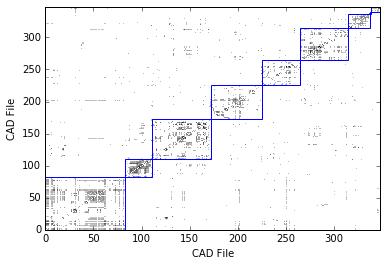

In [128]:
# cluster analysis
partition = community.best_partition(g)
numberOfCommunities = len(list(set([k for k in partition.values()]))) # get number of communities
print('Number of Communities:', numberOfCommunities)
mod = community.modularity(partition, g)
print('Modularity:', mod)
print('Number of Components:', nx.number_connected_components(g))

sortedPartition = sorted(partition.items(), key=operator.itemgetter(1))

# create a new matrix from the partition
n = np.zeros( ( g.number_of_nodes(), g.number_of_nodes() ) )

for u, v, d in g.edges(data=True):
    for i, item in enumerate(sortedPartition):
        if item[0] == u: break
        
    for j, item in enumerate(sortedPartition):
        if item[0] == v: break
                
    n[i, j] = d['weight']
    n[j, i] = d['weight']

plt.pcolor(n, cmap='Greys', vmin=0, vmax=np.max(m))
plt.xlim(0, g.number_of_nodes())
plt.ylim(0, g.number_of_nodes())
plt.xlabel('CAD File')
plt.ylabel('CAD File')

# adding the rectangles
currentAxis = plt.gca()

start_position = 0
cluster = 0
length = 0
for idx, item in enumerate(sortedPartition):
    #print(idx, item[0], item[1])
    if item[1] != cluster:
        #print('new cluster detected')
        currentAxis.add_patch(Rectangle((start_position, start_position), length, length, facecolor="none", edgecolor='blue', linewidth=1))
        start_position = idx
        cluster = item[1]
        length = 1
    else:
        length = length + 1

# this is the last rectangle
currentAxis.add_patch(Rectangle((start_position, start_position), length, length, facecolor="none", edgecolor='blue', linewidth=1))
plt.show()

In [129]:
# Setting the css styling of the notebook
from IPython.core.display import HTML

def load_css():
    style = open('../extras/custom.css', 'r').read()
    return HTML('<style>'+style+'</style>')

load_css()